## **##### 1.Importing necessary libraries**

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance


from fastai.imports import *
from fastai.tabular.all import *

## **##### 2.Loading datasets**

In [160]:
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [161]:
#New
train_test = pd.concat([train, test], ignore_index=True)

In [162]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [163]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

In [165]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [166]:
train_test.loc[:,['Group']] = train_test.PassengerId.apply(lambda x: x[0:4] )

In [167]:
train_test[['Deck', 'Number', 'Side']] = train_test['Cabin'].str.split('/', expand=True)

In [168]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]
train_test['Name_key']=train_test['SecondName']+train_test['Group']

In [169]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination', ]
transported=['Transported']

In [170]:
train_test = train_test[num_cols+cat_cols+transported].copy()

In [171]:
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')

In [172]:
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)

In [173]:
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)

In [174]:
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns=ohe.get_feature_names_out())

In [175]:
train_test = train_test.drop(cat_cols,axis=1)

In [176]:
train_test = pd.concat([train_test,temp_train],axis=1)

In [177]:
train_test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,Transported,CryoSleep_False,CryoSleep_True,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,0.0,0.0,0.0,0.0,0.0,39.000000,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,25.0,9.0,109.0,549.0,44.0,736.0,24.000000,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,3576.0,43.0,6715.0,49.0,10383.0,58.000000,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,371.0,1283.0,0.0,3329.0,193.0,5176.0,33.000000,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,151.0,70.0,303.0,565.0,2.0,1091.0,16.000000,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12966,17.0,847.0,0.0,10.0,144.0,1018.0,42.000000,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12967,0.0,0.0,0.0,0.0,0.0,0.0,28.771969,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,3203.0,28.771969,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [178]:
train = train_test[train_test['Transported'].notnull()].copy()

In [179]:
train.Transported =train.Transported.astype('int')

In [180]:
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [181]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [182]:
drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

In [183]:
X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)

Need to formally seperate categorical and continuous data again for the neural network. 

In [184]:
X_cont,X_cat = cont_cat_split(X)
test_cont,test_cat = cont_cat_split(test)

To split train into the training and validation datasets. 

In [198]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(X))

To set up the data for the nueral network, determine the best learning rate, and then run the model. 

In [186]:
to_train = TabularPandas(train, 
                   procs=[Normalize],
                   cat_names = X_cat,
                   cont_names = X_cont,
                   y_names='Transported',
                   y_block = CategoryBlock,
                   splits=splits)

In [187]:
dls = to_train.dataloaders(bs=64)

In [188]:
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.0008317637839354575)

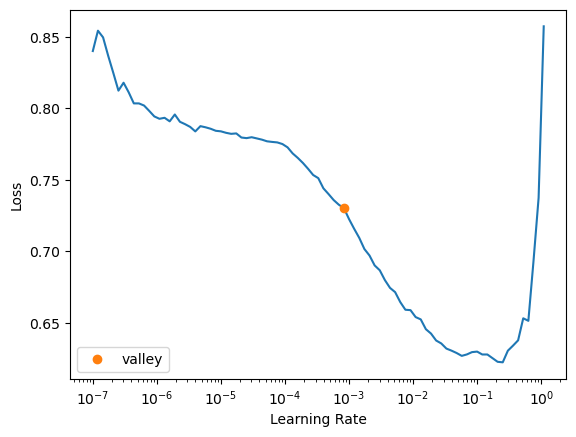

In [189]:
learn.lr_find()

In [190]:
learn.fit_one_cycle(25, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.559562,0.506047,0.753797,00:00
1,0.477312,0.463458,0.786470,00:01
2,0.458824,0.457507,0.785550,00:00
3,0.458168,0.466170,0.778647,00:01
4,0.451387,0.455032,0.786931,00:01
5,0.452413,0.448586,0.787851,00:01
6,0.445965,0.462677,0.762080,00:01
7,0.450502,0.457409,0.775886,00:01
8,0.428027,0.444157,0.789231,00:01
9,0.433673,0.435112,0.798435,00:00


In [191]:
learn.show_results()

,RoomService,Spa,VRDeck,Expenses,CryoSleep_False,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Transported,Transported_pred
0,1.118298,-0.274677,-0.262802,-0.156934,0.762983,-0.169459,-0.320689,-0.310406,-0.238884,3.007680,-0.722710,-0.644858,-0.024777,-0.969770,0.969770,0.0,0.0
1,-0.327120,-0.274677,-0.252885,0.941185,0.762983,-0.169459,-0.320689,-0.310406,4.185892,-0.332479,-0.722710,-0.644858,-0.024777,-0.969770,0.969770,1.0,1.0
2,3.638012,-0.274677,-0.267309,0.811953,0.762983,-0.169459,-0.320689,-0.310406,4.185892,-0.332479,-0.722710,-0.644858,-0.024777,1.031148,-1.031148,0.0,0.0
3,-0.339140,-0.274677,0.456589,-0.224728,0.762983,-0.169459,-0.320689,-0.310406,-0.238884,-0.332479,1.383713,-0.644858,-0.024777,-0.969770,0.969770,0.0,0.0
4,-0.226451,-0.274677,-0.244772,-0.261097,0.762983,-0.169459,-0.320689,-0.310406,-0.238884,-0.332479,1.383713,-0.644858,-0.024777,1.031148,-1.031148,0.0,0.0
5,-0.340642,-0.274677,-0.267309,-0.508615,-1.310651,-0.169459,-0.320689,-0.310406,-0.238884,-0.332479,-0.722710,1.550691,-0.024777,1.031148,-1.031148,1.0,1.0
6,4.874580,-0.274677,-0.267309,0.798888,0.762983,-0.169459,-0.320689,-0.310406,-0.238884,-0.332479,1.383713,-0.644858,-0.024777,-0.969770,0.969770,0.0,0.0
7,0.778730,-0.271250,-0.267309,0.326450,0.762983,-0.169459,-0.320689,-0.310406,-0.238884,-0.332479,1.383713,-0.644858,-0.024777,-0.969770,0.969770,0.0,0.0
8,-0.340642,-0.274677,-0.267309,-0.508615,-1.310651,-0.169459,-0.320689,-0.310406,-0.238884,-0.332479,1.383713,-0.644858,-0.024777,-0.969770,0.969770,1.0,1.0


To use the model to predict the results for the test dataset. Since a neural network creates a 2 column tensor prediction, the labels were created to only show the final prediction. And then they were fitted into the submission dataframe. 

In [192]:
test_dl = learn.dls.test_dl(test)

In [193]:
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [194]:
preds

tensor([[0.3261, 0.6739],
        [0.9394, 0.0606],
        [0.0073, 0.9927],
        ...,
        [0.0161, 0.9839],
        [0.2998, 0.7002],
        [0.3261, 0.6739]])

In [195]:
nn_labels = np.argmax(preds, 1)

In [196]:
labels

tensor([1, 0, 1,  ..., 1, 1, 1])

In [197]:
sample['Transported'] = labels

#This converts the numbers to True/False values
sample['Transported']=sample['Transported']>0.5
sample.to_csv('submit_nn_best_data.csv', index=False)

Score with basic NN is over 0.79. Kaggle score is 0.80406.

Using a 2 layer NN produces a Kaggle score of 0.80196.

Normalizing the data improves the Kaggle score to 0.8057.

Eliminating the splits and thus the validation set didn't work. The model wouldn't run. Reducing the splits from 20% to 5% produced a Kaggle score of 0.79284. Increasing the splits to 25% produced a Kaggle score of 0.80266.